#### Importando Bibliotecas

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Parâmetros
symbol = 'AAPL'
start_date = '2018-01-01'
end_date = '2024-07-20'

In [3]:
# Coleta dos dados
df = yf.download(symbol, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Visualização inicial
print("Dados brutos:")
print(df.head())

Dados brutos:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.426823  40.436212  39.722768  39.933986  102223600
2018-01-03  40.419800  40.964271  40.356437  40.490206  118071600
2018-01-04  40.607536  40.710798  40.384586  40.492539   89738400
2018-01-05  41.069866  41.156698  40.612231  40.703758   94640000
2018-01-08  40.917320  41.213022  40.818749  40.917320   82271200


In [7]:
# Pegar os 60 últimos valores de fechamento
ultimos_60 = df['Close'].tail(60).values.tolist()


# Exibir para colar na API
print(ultimos_60)

[[168.00534057617188], [168.87013244628906], [168.28366088867188], [172.4584503173828], [169.30747985839844], [168.28366088867188], [171.99127197265625], [182.2791748046875], [180.61917114257812], [181.30502319335938], [181.64300537109375], [183.46202087402344], [182.19793701171875], [185.4128875732422], [186.55751037597656], [188.8368682861328], [188.95631408691406], [188.9861602783203], [190.15072631835938], [191.4546356201172], [190.01138305664062], [186.0100860595703], [189.0956573486328], [189.10562133789062], [189.40420532226562], [190.39956665039062], [191.3551025390625], [193.12681579589844], [193.4453125], [194.95823669433594], [193.57470703125], [195.97348022460938], [192.22103881835938], [206.18572998046875], [212.0782012939453], [213.24273681640625], [211.50086975097656], [215.6614227294922], [213.29249572753906], [208.70394897460938], [206.524169921875], [207.17112731933594], [208.0968017578125], [212.25733947753906], [213.1033935546875], [209.6395721435547], [215.74104309

In [9]:
# Selecionar apenas a coluna de fechamento
data = df[['Close']].copy()
data.dropna(inplace=True)

In [10]:
# Normalizar os dados (escala entre 0 e 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

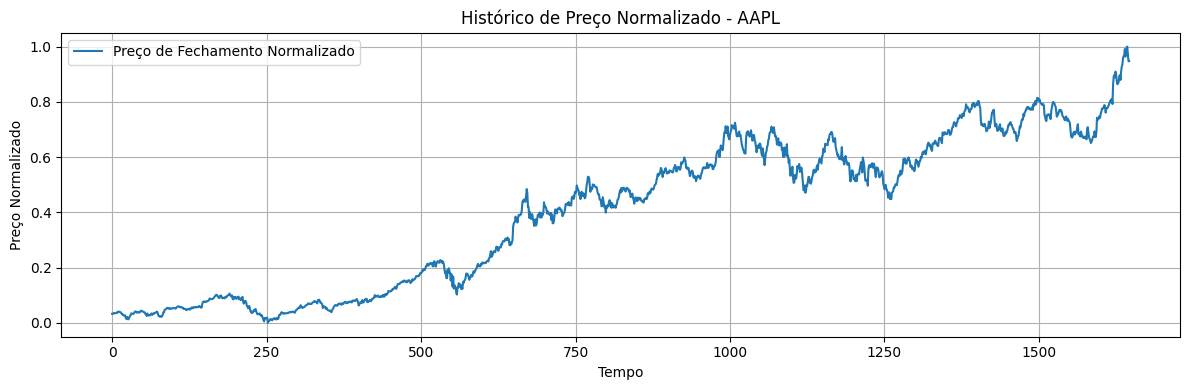

In [11]:
# Plotar os dados normalizados
plt.figure(figsize=(12, 4))
plt.plot(data_scaled, label='Preço de Fechamento Normalizado')
plt.title(f'Histórico de Preço Normalizado - {symbol}')
plt.xlabel('Tempo')
plt.ylabel('Preço Normalizado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Converter para DataFrame para etapas futuras
df_scaled = pd.DataFrame(data_scaled, columns=['Close_Scaled'], index=data.index)

### Janelas de Tempo

In [13]:
import numpy as np

# Função para criar janelas de tempo
def create_sequences(dataset, window_size=60):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Criar janelas (usando df_scaled da etapa anterior)
window_size = 60
X, y = create_sequences(data_scaled, window_size)

# Redimensionar para formato esperado pelo LSTM: [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Dividir treino/teste (80% treino, 20% teste)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### Construir e Treinar Modelo

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construção do modelo
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # saída única

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


c:\Users\Adriano\Desktop\Estudos E oUTROS\Fiap\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0442 - val_loss: 0.0082
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_l

#### Avaliar Modelo

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
MAE: 5.73
RMSE: 7.28


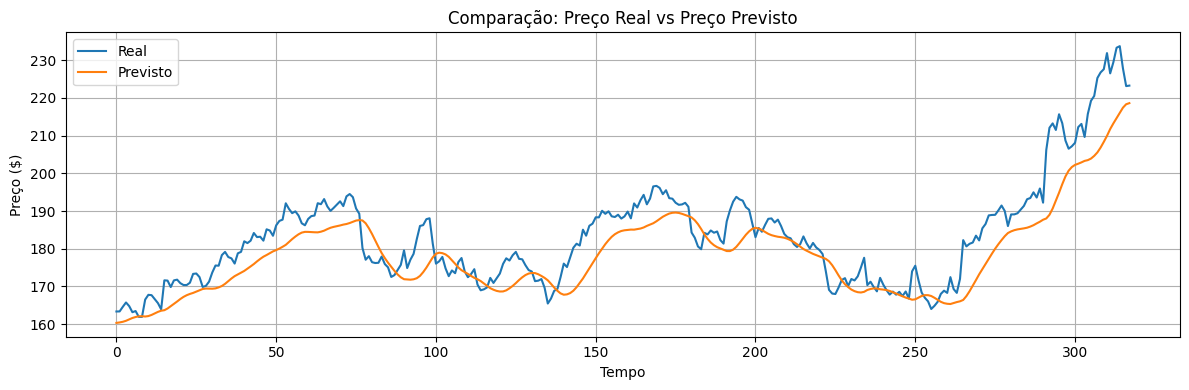

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Previsões
predictions = model.predict(X_test)

# Reverter a normalização para interpretar melhor
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_real = scaler.inverse_transform(predictions)

# Avaliação
mae = mean_absolute_error(y_test_real, predictions_real)
rmse = math.sqrt(mean_squared_error(y_test_real, predictions_real))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# Plotar previsão vs real
plt.figure(figsize=(12, 4))
plt.plot(y_test_real, label='Real')
plt.plot(predictions_real, label='Previsto')
plt.title('Comparação: Preço Real vs Preço Previsto')
plt.xlabel('Tempo')
plt.ylabel('Preço ($)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

### Salvar Modelo

In [16]:
# Salvar modelo treinado no formato HDF5
model.save("lstm_model_aapl.h5")
print("Modelo salvo como 'lstm_model_aapl.h5'")

Modelo salvo como 'lstm_model_aapl.h5'


### Carregar Modelo

In [17]:
from tensorflow.keras.models import load_model

# Carregar o modelo
model = load_model("lstm_model_aapl.h5")
print("Modelo carregado com sucesso!")

Modelo carregado com sucesso!
